In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras

2023-01-13 13:02:54.954189: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-13 13:02:54.961906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jaskirat/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-13 13:02:54.961925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
plt.rcParams.update({'figure.max_open_warning': 0})

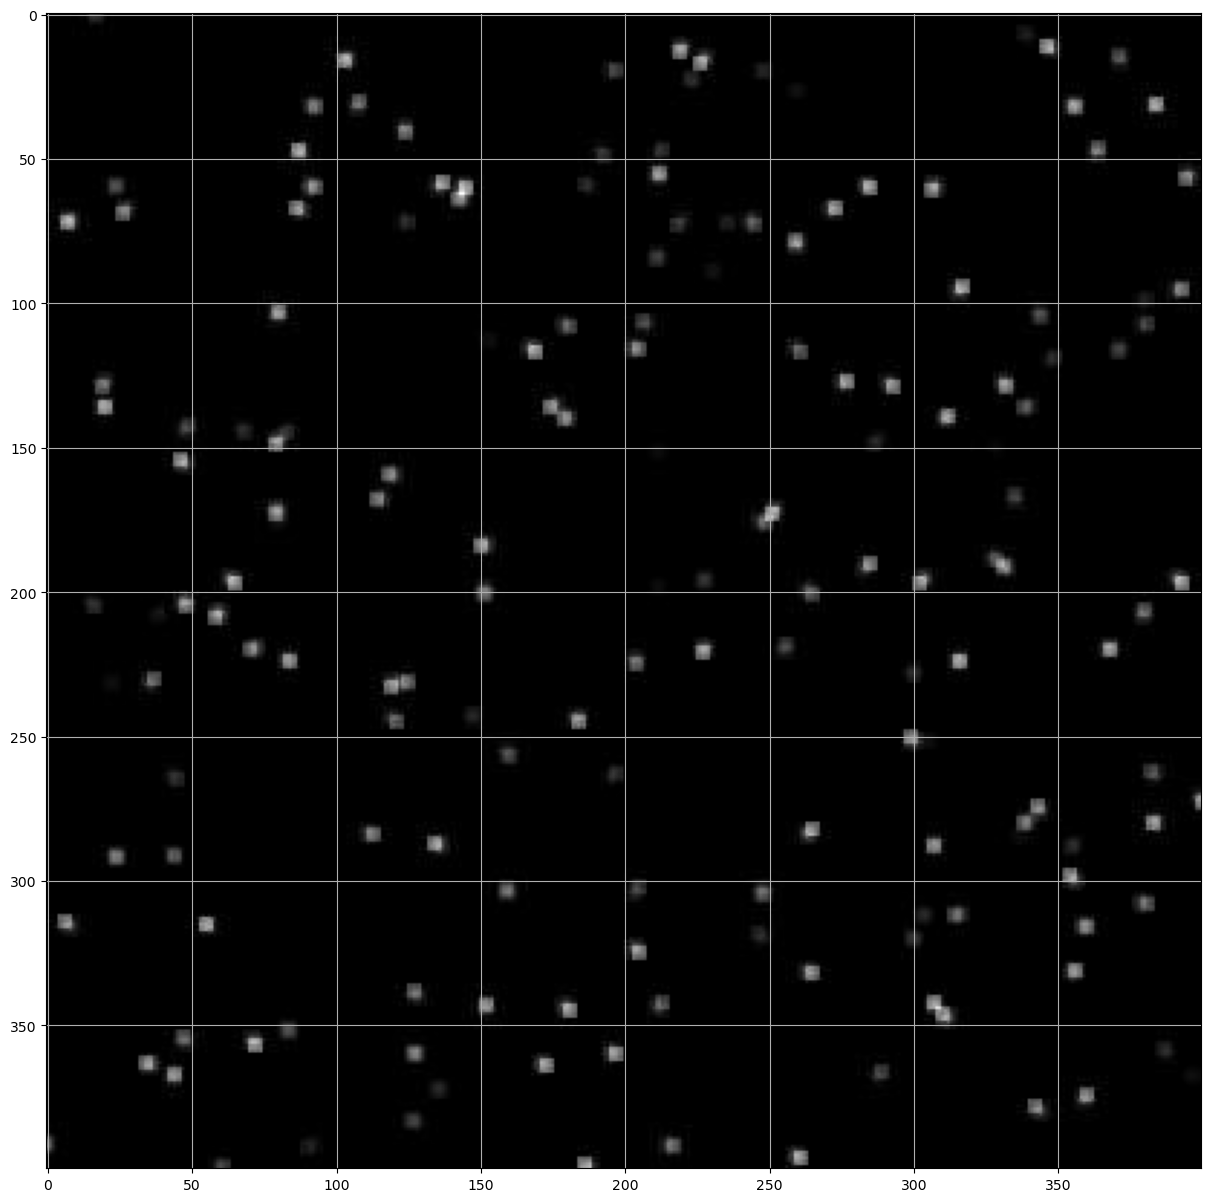

In [3]:
source = cv2.imread("gussian_conv.jpg",0)
fig = plt.figure(figsize=(15,15))
plt.grid()
plt.imshow(source, cmap="gray")

In [4]:
def gradient(pt1, pt2):
    if (pt2[0]-pt1[0] != 0):
        return (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])
    else:
        return math.tan(math.radians(90))

def getangle(pt1,pt2,pt3):
#     pt1,pt2,pt3,pt4 =    data['im'][-4:]
    #last_points = pts[-4:]
    #pt2 = pts[-1][0]
    #pt1 = pts[-2][0]
    #pt3 = pts[-2][1]
#     print(f"point1: {pt1} \n point2: {pt2} \n point3 : {pt3}")
    m1 = gradient(pt1, pt2)
    m2 = gradient(pt2, pt3)
    if m2*m1!=-1:
        angR = math.atan((m2 - m1) / (1 + (m2 * m1)))
        angD = math.degrees(angR)
        return angD
    else:
        angD = 90
        return angD
    
def grid_info(img, grid_loc, grid_size, star):
    grid = img[grid_loc[0]:grid_loc[0]+grid_size[0], grid_loc[1]:grid_loc[1]+grid_size[1]].copy()
    tr = grid.copy()

    points = []
    intensity = []
    angle = []
    distance = [0]

    for i in range(star):
        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(tr)
        tr = cv2.circle(tr, maxLoc, 5, (0, 0, 0), -1)
        grid = cv2.circle(grid, maxLoc, 5, (255,0,0), 2)
        points.append(maxLoc)
        intensity.append(maxVal)

    for i in range(star-1):
        grid = cv2.line(grid, points[i], points[i+1], (255,0,0), 2)
        distance.append(float(f'{(math.dist(points[i], points[i+1])):.2f}')+distance[i])
        
    for i in range(star-2):
        angle.append(f'{(getangle(points[i], points[i+1], points[i+2])):.2f}')

    points = np.array(points)
    intensity = np.array(intensity)
#     distance = normalize(np.array(distance).reshape(-1, 1))
#     distance =  np.linalg.norm(np.array(distance).reshape(1, -1))

#     txt = "Points: {}\nIntensity: {}\nDistance: {}".format(points, intensity, distance)
    
    print("Points: ", points)
    print("Intensity: ", intensity)
    print("Distance: ", distance)
    print("Angle: ", angle)
    
    fig, ax = plt.subplots(1,2, figsize=(9,4))
    fig.suptitle("Grid Location: {}".format(grid_loc), size=15, fontweight="bold")
    ax[0].imshow(grid)
    ax[1].plot(distance, intensity)
#     fig.text(.5, -0.25, txt, ha='center')
    plt.tight_layout()

Points:  [[143  62]
 [ 64 195]
 [  8  71]
 [168 115]]
Intensity:  [250. 195. 191. 190.]
Distance:  [0, 154.69, 290.75, 456.69]
Angle:  ['-55.01', '-50.32']


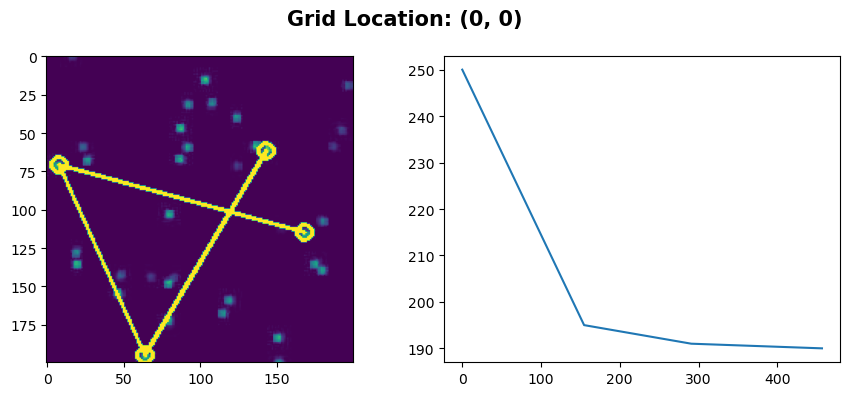

In [5]:
grid_info(source, (0,0), (200,200), 4)

In [6]:
# for i in range(0,1000,200):
#     for j in range(0,1000,200):
#         grid_info(source, (i,j), (200,200), 5)

In [7]:
def bright_points(img, no_points, connect_dots=False):
    
    img = np.array(img, dtype='uint8')
    bright = img.copy()
    tr = bright.copy()
    
    points = []
    intensity = []
    
    for i in range(no_points):
        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(tr)
        tr = cv2.circle(tr, maxLoc, 5, (0, 0, 0), -1)
        bright = cv2.circle(bright, maxLoc, 5, (255,0,0), 2)
        points.append(maxLoc)
        intensity.append(maxVal)
        
    if connect_dots:
        for i in range(len(points)-1):
            bright = cv2.line(bright, points[i], points[i+1], (255,0,0), 1)
        fig = plt.figure()
        plt.imshow(bright)
        
    return (points, intensity)

def get_cumulative_dist(points, intensity, plot=False):
    distance = [0]
    for i in range(len(points)-1):
        distance.append(float(float("%.2f" % math.dist(points[i], points[i+1])))+distance[i])
    if plot:
        fig = plt.figure()
        plt.plot(distance, intensity)
    
    return distance

def get_angles(points):
    angles = [0]
    for i in range(len(points)-2):
        angles.append(float(f'{(getangle(points[i], points[i+1], points[i+2])):.2f}'))
    return angles

def get_sq(img, points, sq_size):

    img = cv2.copyMakeBorder(img, int(sq_size[1]/2), int(sq_size[1]/2), int(sq_size[0]/2), int(sq_size[0]/2), cv2.BORDER_CONSTANT, None)

    images = []
    sq_size = np.array(sq_size)
    points = np.array(points)
    points += 100
#     print(points.shape)
    for i in range(len(points)):
        (x,y) = (points[i][0]-int(sq_size[0]/2),points[i][1]-int(sq_size[1]/2))
        crop = img[y:y+sq_size[0], x:x+sq_size[1]]
#     print(points,"\n")
#     plt.imshow(crop)
        crop = crop.tolist()
        images.append(crop)
    return images

def get_test_sq(img, sq_size, sq_loc, plot=False):
    img = cv2.copyMakeBorder(img, int(sq_size[1]/2), int(sq_size[1]/2), int(sq_size[0]/2), int(sq_size[0]/2), cv2.BORDER_CONSTANT, None)

    (x,y) = (sq_loc[0]-int(sq_size[0]/2),sq_loc[1]-int(sq_size[1]/2))
    crop = img[y:y+sq_size[0], x:x+sq_size[1]]
    if plot:
        sq = img.copy()
        sq = cv2.rectangle(sq, (x,y), (x+sq_size[0], y+sq_size[1]), (255,0,0), 2)
        fig, ax = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'width_ratios': [3, 1]})
        ax[0].imshow(sq)
        ax[1].imshow(crop)
    return crop

In [8]:
grid_size = (200,200)
point_num = 5

bright = source.copy()
grids = 0

points = []

for i in range(0,1000,grid_size[0]):
    for j in range(0,1000,grid_size[1]):
        (pts,intensity) = bright_points(source[i:i+grid_size[0], j:j+grid_size[1]], point_num)
        pts = np.array(pts)
        pts[:,1:2]+=i
        pts[:,:1]+=j
        pts = pts.tolist()
        points.append(pts)
        grids +=1
        
points = np.array(points)
points = points.reshape((points.shape[0]*points.shape[1],2))

for i in points:
    bright = cv2.circle(bright, i, 5, (255,0,0), 2)
    bright = cv2.rectangle(bright, i-int(grid_size[0]/2), i+int(grid_size[1]/2), (255,0,0), 1)

fig = plt.figure(figsize=(15,15))
plt.grid()
plt.imshow(bright)
# plt.gca().invert_yaxis()
plt.tight_layout()

# get_sq(bright, points, grid_size)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


In [ ]:
images = np.array(get_sq(source, points, (200,200)))
distances = []
angles = []


for i in range(len(points)):
    p = bright_points(images[i],7)
    distances.append(get_cumulative_dist(p[0], p[1]))
    angles.append(get_angles(p[0]))
    
distances = np.array(distances)
angles = np.array(angles)

print("Distances: ", distances.shape)
print("Angles: ", angles.shape)

In [ ]:
# x = np.arange(0,25)
# np.repeat(x, point_num)
print(grids)

In [ ]:
data = {"Sq_no.": list(range(grids*point_num)), "Center_cordinate": points.tolist(), "Distances":distances.tolist(), "Angles":angles.tolist()}
dataframe = pd.DataFrame(data)
dataframe.head(40)

In [ ]:
for i in range(1,distances.shape[1]):
    dataframe["d{}".format(i)] = distances[:, i:i+1]

for i in range(1,angles.shape[1]):    
    dataframe["a{}". format(i)] = angles[:, i:i+1]
    
# for i in range(1,points.shape[1]):    
#     dataframe["x"] = points[:, i:i+1]
#     dataframe["y"] = points[:, ]

dataframe.head()

In [ ]:
def error(x,y):
    return abs(x-y)

def find_indices(list_to_check, item_to_find):
    array = np.array(list_to_check)
    indices = np.where(array == item_to_find)[0]
    return list(indices)

In [ ]:
# sns.pairplot(dataframe, hue='Sq_no.')

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(dataframe['d1'], dataframe['d2'], dataframe['d3'], c=dataframe['Sq_no.'], s=60)
# ax.view_init(30, 185)
# plt.show()

In [ ]:
points.shape

In [ ]:
X_train = dataframe.loc[:, ~dataframe.columns.isin(["Sq_no.", "Center_cordinate", "Distances", "Angles"])]
Y_train = dataframe["Sq_no."]
print(Y_train)
print(X_train)

In [ ]:
# MultiLabelBinarizer().fit_transform(X_train)

In [ ]:
model = SVC()
model.fit(X=np.array(X_train), y=np.array(Y_train))

In [ ]:
model.predict(X_train[4:5])

In [ ]:
crop = get_test_sq(source, (200,200), (700,900), True)
b_points = bright_points(crop, 7, True)
dist = get_cumulative_dist(b_points[0], b_points[1])
ang = get_angles(b_points[0])

X_test = np.array(dist[1:]+ang[1:]).reshape((1,11))
# print(X_train[4:5].shape)
# print(X_test)
# pred = model.predict(X_test)
# pred[0]
# print("pred: ", pred)
# rect = dataframe.iloc[pred[0]]["Center_cordinate"]
# get_test_sq(source, (200,200), rect, True)

er = []

mat = np.array(X_train)
errors = []
for i in range(mat.shape[0]):
    errors.append(np.sum(error(mat, X_test)))

ind = find_indices(errors, 0)
ind = list(set(ind))

for i in ind:
    rect = dataframe.iloc[i]["Center_cordinate"]
    get_test_sq(source, (200,200), rect, True)
    print(rect)

In [ ]:
dataframe.iloc[ind[0]]

In [ ]:
print(ind)
# np.sum(error(mat[ind[2]], X_test))
# mat.shape

In [ ]:
st = "jaskirat was here."
find_indices(list(), 'a')

In [ ]:
ann = keras.Sequential([
    keras.layers.Dense(2, input_shape=(7, ), activation='sigmoid')
])

ann.compile(
   optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.sparse_categorical_crossentropy,
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

ann.fit(X_train, Y_train, epochs=5)

In [ ]:
model1 = keras.Sequential()
model1.add(keras.layers.Dense(128, activation='relu', input_dim=7))
model1.add(keras.layers.Dense(125, activation='softmax'))
model1.compile(optimizer='adam', loss=' categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train, Y_train)